<a href="https://colab.research.google.com/github/lucasresck/deep-learning-and-applications/blob/main/cnn/cnn_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN architectures comparison

[Deep Learning and Applications](https://emap.fgv.br/sites/emap.fgv.br/files/ementa_deep_learning_and_applications.pdf)
summer course (2021, FGV).

**Group**:
- Humberto Seghetto dos Santos (PUC-Rio)
- Lucas Emanuel Resck Domingues (FGV-EMAp)

## Description

We will make various experiments with CNNs layers, activation functions and regularization techniques, and we will compare the results.

1. **Objective**: Use or create a deep CNN for COVID data set.
2. **Activities**: Create a deep model in PyTorch.
3. **Experiments**:
    - Increment number layer, from 1 to 5, and  analyze the results.
    - Experiment by changing the activation  functions (Tanh, ReLU) and analyze the results.
    - Experiment changing regularization strategies (1. without regularization; 2. with batch normalization; 3. with dropout).
    - With  a CNN with 3 layer, use kernel size:
        - (7x7,5x5,3x3)
        - (5x5,5x5,3x3)
        - (3x3,3x3,3x3)
4. Conclude from the results.


## Setup

We install the required libraries, set up the GPU support and also set up the Kaggle support.

In [ ]:
# Install libraries
!pip install -q kaggle  # For Kaggle dataset
!pip install -q split-folders  # Split the data

In [ ]:
# Import libraries
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import splitfolders
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

sns.set()

In [ ]:
# GPU setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
# Setup for downloading the Kaggle dataset
files.upload()  # Upload the Kaggle user API key
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Data

We download the COVID dataset from Kaggle, and we split the data.

In [ ]:
# Download the files
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Unzip them
!unzip -q covid19-radiography-database.zip

# Remove files and folders
!rm 'covid19-radiography-database.zip'
!rm 'COVID-19 Radiography Database/COVID.metadata.xlsx'
!rm 'COVID-19 Radiography Database/NORMAL.metadata.xlsx'
!rm 'COVID-19 Radiography Database/README.md.txt'
!rm -rf 'COVID-19 Radiography Database/Viral Pneumonia'
!rm 'COVID-19 Radiography Database/Viral Pneumonia.metadata.xlsx'

# Split data
splitfolders.ratio(
    'COVID-19 Radiography Database',
    output='data',
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)

# Delete old files
!rm -rf 'COVID-19 Radiography Database'

 98% 1.11G/1.14G [00:04<00:00, 227MB/s]
100% 1.14G/1.14G [00:04<00:00, 246MB/s]


Copying files: 2541 files [00:16, 155.78 files/s]


The resulting directory looks like that:

```
data/
    train/
        COVID/
            img1.jpg
            ...
        NORMAL/
            imga.jpg
            ...
    val/
        COVID/
            img2.jpg
            ...
        NORMAL/
            imgb.jpg
            ...
    test/
        COVID/
            img3.jpg
            ...
        NORMAL/
            imgc.jpg
            ...
```



We import the data sets and create the data loaders.

In [ ]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(256)
])
train_set = torchvision.datasets.ImageFolder(
    root='data/train',
    transform=transformation
)
val_set = torchvision.datasets.ImageFolder(
    root='data/val',
    transform=transformation
)
test_set = torchvision.datasets.ImageFolder(
    root='data/test',
    transform=transformation
)

In [ ]:
print('The number of images is {}.'.format(len(train_set)+len(val_set)+len(test_set)))

The number of images is 2541.


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False
)

Here's an example of an image of the train dataset.

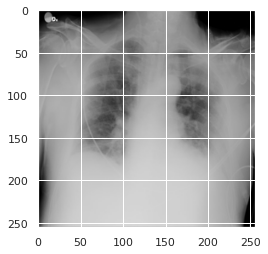

In [ ]:
plt.imshow(transforms.ToPILImage()(train_set[0][0]));

## Experiments

Here we perform the experiments proprosed in the beggining of our notebook.

In [ ]:
# Hyperparameters
lr = 0.001
n_epochs = 3

### Layers

We vary the number of layers of the CNN and discuss the results.

#### 1 layer

In [ ]:
class CNN_1_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(
            in_features=16*128*128,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.reshape(-1, 16*128*128)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x


cnn_1_layer = CNN_1_layer().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_1_layer.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, loss_function):
    losses = []
    val_losses = []
    val_accs = []
    for epoch in range(n_epochs):
        running_loss = 0
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()

            imgs, labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(
                    epoch+1,
                    n_epochs,
                    i+1,
                    len(train_loader),
                    loss.item()
                ))

        running_loss = running_loss/len(train_loader)
        print('Epoch [{}/{}], Mean loss: {:.4f}' .format(
            epoch+1,
            n_epochs,
            running_loss
        ), end='')
        losses.append(running_loss) 

        model.eval()
        val_loss = 0
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
        val_acc = correct/total
        val_accs.append(val_acc)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(', Val loss: {:.4f}, Val acc: {:.3f}'.format(val_loss, val_acc))

In [ ]:
train(cnn_1_layer, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.5067
Epoch [1/3], Step [20/32], Loss: 0.0699
Epoch [1/3], Step [30/32], Loss: 0.1260
Epoch [1/3], Mean loss: 0.5742, Val loss: 0.1178, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.1275
Epoch [2/3], Step [20/32], Loss: 0.1008
Epoch [2/3], Step [30/32], Loss: 0.0998
Epoch [2/3], Mean loss: 0.0863, Val loss: 0.0646, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.0382
Epoch [3/3], Step [20/32], Loss: 0.0202
Epoch [3/3], Step [30/32], Loss: 0.1488
Epoch [3/3], Mean loss: 0.0492, Val loss: 0.0559, Val acc: 0.976


In [ ]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct/total
    print('The accuracy of the model on test set is {:.4f}.'.format(acc))
    return acc

In [ ]:
acc_layers = [test(cnn_1_layer)]

The accuracy of the model on test set is 0.9647.


#### 2 layers

In [ ]:
class CNN_2_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(64*64*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(-1, 64*64*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_2_layers = CNN_2_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_2_layers.parameters(), lr=lr)

In [ ]:
train(cnn_2_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.5035
Epoch [1/3], Step [20/32], Loss: 0.0744
Epoch [1/3], Step [30/32], Loss: 0.1557
Epoch [1/3], Mean loss: 0.6266, Val loss: 0.0888, Val acc: 0.969
Epoch [2/3], Step [10/32], Loss: 0.1359
Epoch [2/3], Step [20/32], Loss: 0.0928
Epoch [2/3], Step [30/32], Loss: 0.0656
Epoch [2/3], Mean loss: 0.0559, Val loss: 0.0593, Val acc: 0.980
Epoch [3/3], Step [10/32], Loss: 0.1401
Epoch [3/3], Step [20/32], Loss: 0.0371
Epoch [3/3], Step [30/32], Loss: 0.0600
Epoch [3/3], Mean loss: 0.0272, Val loss: 0.0560, Val acc: 0.984


In [ ]:
acc_layers.append(test(cnn_2_layers))

The accuracy of the model on test set is 0.9843.


#### 3 layers

In [ ]:
class CNN_3_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_3_layers = CNN_3_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_3_layers.parameters(), lr=lr)

In [ ]:
train(cnn_3_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.1514
Epoch [1/3], Step [20/32], Loss: 0.2453
Epoch [1/3], Step [30/32], Loss: 0.0608
Epoch [1/3], Mean loss: 0.2112, Val loss: 0.0824, Val acc: 0.969
Epoch [2/3], Step [10/32], Loss: 0.1064
Epoch [2/3], Step [20/32], Loss: 0.0422
Epoch [2/3], Step [30/32], Loss: 0.0444
Epoch [2/3], Mean loss: 0.0731, Val loss: 0.0714, Val acc: 0.957
Epoch [3/3], Step [10/32], Loss: 0.0375
Epoch [3/3], Step [20/32], Loss: 0.0912
Epoch [3/3], Step [30/32], Loss: 0.0605
Epoch [3/3], Mean loss: 0.0557, Val loss: 0.0576, Val acc: 0.980


In [ ]:
acc_layers.append(test(cnn_3_layers))

The accuracy of the model on test set is 0.9725.


#### 4 layers

In [ ]:
class CNN_4_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(16*16*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.reshape(-1, 16*16*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_4_layers = CNN_4_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_4_layers.parameters(), lr=lr)

In [ ]:
train(cnn_4_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.5078
Epoch [1/3], Step [20/32], Loss: 0.1437
Epoch [1/3], Step [30/32], Loss: 0.2772
Epoch [1/3], Mean loss: 0.3711, Val loss: 0.1069, Val acc: 0.965
Epoch [2/3], Step [10/32], Loss: 0.2262
Epoch [2/3], Step [20/32], Loss: 0.0665
Epoch [2/3], Step [30/32], Loss: 0.0387
Epoch [2/3], Mean loss: 0.0993, Val loss: 0.1118, Val acc: 0.969
Epoch [3/3], Step [10/32], Loss: 0.0178
Epoch [3/3], Step [20/32], Loss: 0.1268
Epoch [3/3], Step [30/32], Loss: 0.1037
Epoch [3/3], Mean loss: 0.0695, Val loss: 0.0799, Val acc: 0.969


In [ ]:
acc_layers.append(test(cnn_4_layers))

The accuracy of the model on test set is 0.9569.


#### 5 layers

In [ ]:
class CNN_5_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv5 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(8*8*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = x.reshape(-1, 8*8*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_5_layers = CNN_5_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_5_layers.parameters(), lr=lr)

In [ ]:
train(cnn_5_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.6331
Epoch [1/3], Step [20/32], Loss: 0.1257
Epoch [1/3], Step [30/32], Loss: 0.0832
Epoch [1/3], Mean loss: 0.3807, Val loss: 0.1462, Val acc: 0.965
Epoch [2/3], Step [10/32], Loss: 0.0464
Epoch [2/3], Step [20/32], Loss: 0.1434
Epoch [2/3], Step [30/32], Loss: 0.0417
Epoch [2/3], Mean loss: 0.1004, Val loss: 0.0788, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.0205
Epoch [3/3], Step [20/32], Loss: 0.0558
Epoch [3/3], Step [30/32], Loss: 0.0298
Epoch [3/3], Mean loss: 0.0706, Val loss: 0.0749, Val acc: 0.976


In [ ]:
acc_layers.append(test(cnn_5_layers))

The accuracy of the model on test set is 0.9725.


#### Comparison

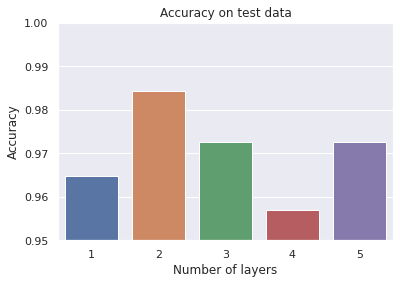

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=list(range(1, 6)), y=acc_layers, ax=ax)
ax.set_ylim([0.95, 1])
plt.title('Accuracy on test data')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.show()

With our results, we conclude that the best model was the one with **2 layers**.

### Activation functions

We experiment with some activate functions and discuss the results. Because of the experiments with various number of layers, we will choose to work with 2 layers.

#### ReLU

It was already fitted in the previous section (2 layers CNN).

In [ ]:
acc_activation = [acc_layers[1]]

#### Tanh

In [ ]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(64*64*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.tanh(self.pool(self.conv1(x)))
        x = self.tanh(self.pool(self.conv2(x)))
        x = x.reshape(-1, 64*64*32)
        x = self.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_tanh = CNN_tanh().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_tanh.parameters(), lr=lr)

In [ ]:
train(cnn_tanh, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 2.1544
Epoch [1/3], Step [20/32], Loss: 1.0883
Epoch [1/3], Step [30/32], Loss: 0.7429
Epoch [1/3], Mean loss: 1.6027, Val loss: 0.8560, Val acc: 0.528
Epoch [2/3], Step [10/32], Loss: 0.7363
Epoch [2/3], Step [20/32], Loss: 0.7022
Epoch [2/3], Step [30/32], Loss: 0.6916
Epoch [2/3], Mean loss: 0.7245, Val loss: 0.7002, Val acc: 0.472
Epoch [3/3], Step [10/32], Loss: 0.6898
Epoch [3/3], Step [20/32], Loss: 0.6994
Epoch [3/3], Step [30/32], Loss: 0.6775
Epoch [3/3], Mean loss: 0.6940, Val loss: 0.6912, Val acc: 0.528


In [ ]:
acc_activation.append(test(cnn_tanh))

The accuracy of the model on test set is 0.5294.


#### Comparison

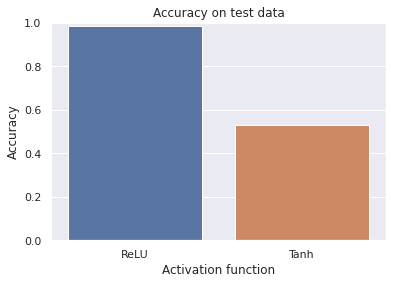

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['ReLU', 'Tanh'], y=acc_activation, ax=ax)
ax.set_ylim([0, 1])
plt.title('Accuracy on test data')
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.show()

With our results, we conclude that the best model was by far the one with **ReLU**.

### Regularization strategies

We experiment various regularization strategies.

#### Without regularization

Consider the 2 layers CNN with ReLU.

In [ ]:
acc_regu = [acc_layers[1]]

#### Batch normalization

In [ ]:
class CNN_batch_normalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn_2 = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(64*64*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn_1(self.conv1(x))))
        x = self.pool(self.relu(self.bn_2(self.conv2(x))))
        x = x.reshape(-1, 64*64*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_batch_normalization = CNN_batch_normalization().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_batch_normalization.parameters(), lr=lr)

In [ ]:
train(cnn_batch_normalization, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.5064
Epoch [1/3], Step [20/32], Loss: 0.8964
Epoch [1/3], Step [30/32], Loss: 1.1738
Epoch [1/3], Mean loss: 2.5429, Val loss: 37.7468, Val acc: 0.472
Epoch [2/3], Step [10/32], Loss: 0.0000
Epoch [2/3], Step [20/32], Loss: 0.0000
Epoch [2/3], Step [30/32], Loss: 0.4481
Epoch [2/3], Mean loss: 0.1632, Val loss: 1.9420, Val acc: 0.945
Epoch [3/3], Step [10/32], Loss: 0.4762
Epoch [3/3], Step [20/32], Loss: 0.0547
Epoch [3/3], Step [30/32], Loss: 0.0000
Epoch [3/3], Mean loss: 0.0440, Val loss: 0.1950, Val acc: 0.988


In [ ]:
acc_regu.append(test(cnn_batch_normalization))

The accuracy of the model on test set is 0.9961.


#### Dropout

In [ ]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(64*64*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.dropout(self.relu(self.conv1(x))))
        x = self.pool(self.dropout(self.relu(self.conv2(x))))
        x = x.reshape(-1, 64*64*32)
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

cnn_dropout = CNN_dropout().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_dropout.parameters(), lr=lr)

In [ ]:
train(cnn_dropout, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.3464
Epoch [1/3], Step [20/32], Loss: 0.2627
Epoch [1/3], Step [30/32], Loss: 0.1515
Epoch [1/3], Mean loss: 0.7285, Val loss: 0.2114, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.0974
Epoch [2/3], Step [20/32], Loss: 0.1684
Epoch [2/3], Step [30/32], Loss: 0.0413
Epoch [2/3], Mean loss: 0.1129, Val loss: 0.1369, Val acc: 0.976
Epoch [3/3], Step [10/32], Loss: 0.1091
Epoch [3/3], Step [20/32], Loss: 0.0754
Epoch [3/3], Step [30/32], Loss: 0.0889
Epoch [3/3], Mean loss: 0.0751, Val loss: 0.0993, Val acc: 0.980


In [ ]:
acc_regu.append(test(cnn_dropout))

The accuracy of the model on test set is 0.9647.


#### Comparison

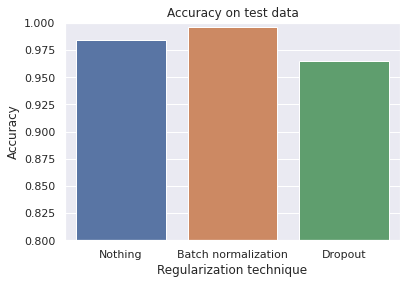

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['Nothing', 'Batch normalization', 'Dropout'], y=acc_regu, ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Regularization technique')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.show()

With our results, we conclude that the best model was the one with batch normalization.

### Kernel size

We experiment various kernel sizes.

#### (7x7, 5x5, 3x3)



In [ ]:
class CNN_753(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 1, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_753 = CNN_753().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_753.parameters(), lr=lr)

In [ ]:
train(cnn_753, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.2064
Epoch [1/3], Step [20/32], Loss: 0.1180
Epoch [1/3], Step [30/32], Loss: 0.1488
Epoch [1/3], Mean loss: 0.3047, Val loss: 0.1112, Val acc: 0.969
Epoch [2/3], Step [10/32], Loss: 0.0530
Epoch [2/3], Step [20/32], Loss: 0.2389
Epoch [2/3], Step [30/32], Loss: 0.1493
Epoch [2/3], Mean loss: 0.1028, Val loss: 0.0720, Val acc: 0.976
Epoch [3/3], Step [10/32], Loss: 0.0623
Epoch [3/3], Step [20/32], Loss: 0.0062
Epoch [3/3], Step [30/32], Loss: 0.0168
Epoch [3/3], Mean loss: 0.0625, Val loss: 0.0623, Val acc: 0.980


In [ ]:
acc_kernel = [test(cnn_753)]

The accuracy of the model on test set is 0.9608.


#### (5x5, 5x5, 3x3)



In [ ]:
class CNN_553(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1, 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_553 = CNN_553().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_553.parameters(), lr=lr)

In [ ]:
train(cnn_553, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.4164
Epoch [1/3], Step [20/32], Loss: 0.0879
Epoch [1/3], Step [30/32], Loss: 0.1611
Epoch [1/3], Mean loss: 0.3083, Val loss: 0.0834, Val acc: 0.961
Epoch [2/3], Step [10/32], Loss: 0.0476
Epoch [2/3], Step [20/32], Loss: 0.1078
Epoch [2/3], Step [30/32], Loss: 0.1677
Epoch [2/3], Mean loss: 0.0826, Val loss: 0.1169, Val acc: 0.969
Epoch [3/3], Step [10/32], Loss: 0.0631
Epoch [3/3], Step [20/32], Loss: 0.0370
Epoch [3/3], Step [30/32], Loss: 0.0121
Epoch [3/3], Mean loss: 0.0657, Val loss: 0.0925, Val acc: 0.972


In [ ]:
acc_kernel.append(test(cnn_553))

The accuracy of the model on test set is 0.9725.


#### (3x3, 3x3, 3x3)



In [ ]:
class CNN_333(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 1, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_333 = CNN_333().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_333.parameters(), lr=lr)

In [ ]:
train(cnn_333, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.0594
Epoch [1/3], Step [20/32], Loss: 0.1830
Epoch [1/3], Step [30/32], Loss: 0.0623
Epoch [1/3], Mean loss: 0.1940, Val loss: 0.0519, Val acc: 0.976
Epoch [2/3], Step [10/32], Loss: 0.0951
Epoch [2/3], Step [20/32], Loss: 0.0102
Epoch [2/3], Step [30/32], Loss: 0.0303
Epoch [2/3], Mean loss: 0.0538, Val loss: 0.0481, Val acc: 0.980
Epoch [3/3], Step [10/32], Loss: 0.0387
Epoch [3/3], Step [20/32], Loss: 0.0275
Epoch [3/3], Step [30/32], Loss: 0.0588
Epoch [3/3], Mean loss: 0.0604, Val loss: 0.0435, Val acc: 0.980


In [ ]:
acc_kernel.append(test(cnn_333))

The accuracy of the model on test set is 0.9843.


#### Comparison

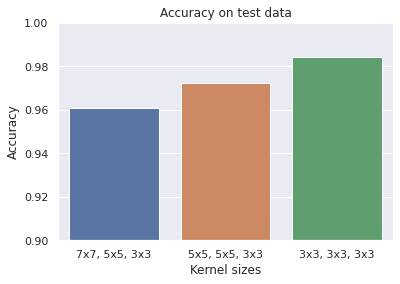

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['7x7, 5x5, 3x3', '5x5, 5x5, 3x3', '3x3, 3x3, 3x3'], y=acc_kernel, ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Kernel sizes')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.show()

The best model was the one with kernel sizes (3x3x3).

## Conclusions

In general, we could conjecture, based on our experiments, the best model for this task has some of these characteristics:
- 2 layers
- ReLU
- Batch normalization
- 3 layers and kernel sizes (3x3x3)

In fact, our model with 2 layers, ReLU and batch normalization performed the best.

It is very important to note that, because of the randomness of the processes, we could have had much different results.

## References

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.